<a href="https://colab.research.google.com/github/jvallalta/monai/blob/main/Monai_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformaciones
En este laboratorio aprenderemos el uso de las transformaciones en MONAI para configurar una canalización de datos para el training.

Primero importaremos componentes MONAI.

In [1]:
%pip install -qU "monai[nibabel]==0.3.0rc2"

import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

import monai
from monai.utils import first
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (
    Transform,
    Randomizable,
    AddChannel,
    Compose,
    LoadNifti,
    Lambda,
    RandSpatialCrop,
    RandSpatialCropd,
    ToTensor,
)

     |████████████████████████████████| 290 kB 5.1 MB/s 


Crearemos un directorio temporal y subiremos algunas imágenes de formato de archivo Nifti de ejemplo que contienen una variedad aleatoria de esferas.

In [3]:
root_dir = tempfile.mkdtemp()
print(root_dir)
filenames = []

for i in range(5):
    im, _ = create_test_image_3d(256, 256, 256)

    filename = f"{root_dir}/im{i}.nii.gz"
    filenames.append(filename)

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, filename)

/tmp/tmpta5wuhvn


# Transformaciones de array
Las transformaciones en MONAI son objetos invocables que aceptan entradas de datos iniciales en un conjunto de datos o transformaciones anteriores. Podemos crearlos y llamarlos directamente sin ninguna infraestructura o configuración del sistema, ya que los componentes de MONAI están diseñados para estar lo más desacoplados posible. Por ejemplo, podemos cargar uno de nuestros archivos Nifti directamente creando la transformación y llamándola

(256, 256, 256) /tmp/tmpta5wuhvn/im0.nii.gz


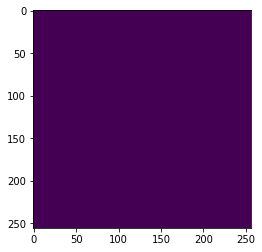

In [9]:
trans = LoadNifti()

img, header = trans(filenames[0])

print(img.shape, header["filename_or_obj"])
plt.imshow(img[128])

Las transformaciones se componen con Compose para crear una secuencia de operaciones. Compose sí mismo siendo una transformación también podemos llamarlo directamente.

In [10]:
trans = Compose([LoadNifti(image_only=True), AddChannel()])

img = trans(filenames[0])

print(img.shape)

(1, 256, 256, 256)


El tipo de img aquí es numpy.ndarray, por lo que para convertir a un tensor de Pytorch como parte de una canalización de datos de entrenamiento, tendríamos ToTensor como la última transformación en nuestra secuencia.

In [11]:
trans = Compose([LoadNifti(image_only=True), AddChannel(), ToTensor()])

img = trans(filenames[0])

print(type(img), img.shape, img.get_device())

<class 'torch.Tensor'> torch.Size([1, 256, 256, 256]) -1


En qué dispositivo se almacena el tensor es un asunto que se abordará en otra parte del proceso de entrenamiento.

Podemos definir nuestra propia operación de transformación personalizada de varias formas. Si se usa un invocable simple como operador, Lambda se puede usar para envolverlo como una transformación. Definimos en este ejemplo una transformación para sumar la imagen en la primera dimensión (ancho) para producir una imagen 2D.

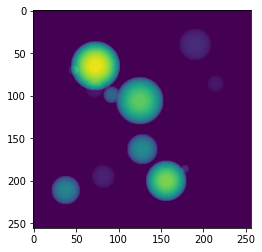

In [12]:
def sum_width(img):
    return img.sum(1)


trans = Compose([LoadNifti(image_only=True), AddChannel(), Lambda(sum_width)])

img = trans(filenames[0])

plt.imshow(img[0])

Todas estas transformaciones de ejemplo hasta ahora han sido deterministas, para definir transformaciones que realizan alguna operación estocástica en los datos de entrada que también queremos heredar de Randomizable. Esta clase se utiliza para aleatorizar variables pero también para distinguir de transformadas deterministas. Veremos por qué esto es importante más adelante en el almacenamiento en caché de cargadores de datos. Por ahora definamos una transformación simple para agregar.


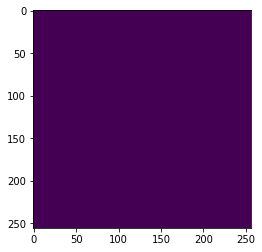

In [17]:
class RandAdditiveNoise(Randomizable, Transform):
    def __init__(self, prob: float = 0.5, max_add: float = 1.0) -> None:
        self.prob = np.clip(prob, 0.0, 1.0)
        self.max_add = max_add
        self._noise = 0

    def randomize(self, data: np.ndarray) -> None:
        self._noise = 0

        if self.R.random() < self.prob:
            noise_array = self.R.rand(*data.shape[1:])[None]
            self._noise = (noise_array * self.max_add).astype(data.dtype)

    def add_noise(self, img: np.ndarray) -> np.ndarray:
        return img + self._noise

    def __call__(self, img: np.ndarray) -> np.ndarray:
        self.randomize(img)
        return self.add_noise(img)


trans = Compose([LoadNifti(image_only=True), AddChannel(), RandAdditiveNoise()])

img = trans(filenames[0])

plt.imshow(img[0, 128])

Ejecute esta celda varias veces para ver que la transformación aleatoria se aplica el 50% del tiempo.

En esta clase tenemos un objeto numpy.random.RandomState para proporcionar valores estocásticos. Esto se puede reemplazar usando Randomizable.set_random_state () para controlar el proceso de aleatorización. El método randomize () es responsable de determinar si la operación aleatoria se realizará basándose en el miembro de probabilidad prob, luego crea la matriz de ruido aleatorio si es así. Esta funcionalidad está en este método para que pueda ser invocada por Compose u otros controladores externos.

# Diccionario de transformaciones
Hasta ahora hemos visto transformaciones que se aplican a matrices Numpy individuales, sin embargo, para la mayoría de los esquemas de entrenamiento se necesita una canalización con múltiples valores. Para abordar esto, MONAI incluye transformaciones para operar en diccionarios de matrices, una para cada transformación de matriz equivalente. Estos se pueden aplicar a valores con nombre en un diccionario de entrada sin modificar los valores sin nombre, por ejemplo, agregar ruido a una imagen y dejar intacta la imagen de la etiqueta asociada.


In [18]:
fn_keys = ("img", "seg")  # filename keys for image and seg files
filenames = []

for i in range(5):
    im, seg = create_test_image_3d(256, 256, 256)

    im_filename = f"{root_dir}/im{i}.nii.gz"
    seg_filename = f"{root_dir}/seg{i}.nii.gz"

    filenames.append({"img": im_filename, "seg": seg_filename})

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, im_filename)

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, seg_filename)

A continuación, importamos las transformaciones equivalentes del diccionario que tienen una d o D anexada a sus nombres:

In [20]:
from monai.transforms import (
    MapTransform,
    AddChanneld,
    LoadNiftid,
    Lambdad,
    ToTensord,
)


El argumento de claves en LoadNiftid se usa para indicar qué claves contienen rutas a archivos Nifti, todos los demás valores en el diccionario de entrada se conservarán. Con este conjunto podemos mirar las claves devueltas al llamar a la transformación.

In [21]:
trans = LoadNiftid(keys=fn_keys)

data = trans(filenames[0])

print(list(data.keys()))

['img', 'seg', 'img_meta_dict', 'seg_meta_dict']



Lambdad aplica el invocable dado a cada matriz nombrada por claves por separado. Podemos usar esto para definir transformaciones que operan en diferentes valores nombrados en el diccionario en diferentes puntos de la secuencia.

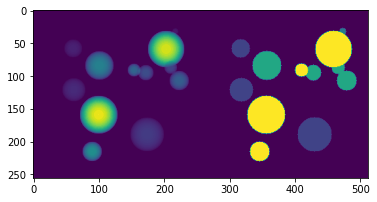

In [22]:
def sum_width(img):
    return img.sum(1)


def max_width(img):
    return img.max(1)


trans = Compose(
    [
        LoadNiftid(fn_keys),
        AddChanneld(fn_keys),
        Lambdad(("img",), sum_width),  # sum the image in the width dimension
        Lambdad(("seg",), max_width),  # take max label in the width dimension
    ]
)

imgd = trans(filenames[0])
img = imgd["img"]
seg = imgd["seg"]

plt.imshow(np.hstack((img[0] * 5 / img.max(), seg[0])))

Lo anterior aplica una operación a un miembro del diccionario y una operación diferente a otro. Una reimplementación razonable de esto en una transformación requeriría retener los nombres de qué miembros aplicar a qué transformación y aplicar las operaciones en un método.

Adaptar transformaciones basadas en matrices para operar sobre diccionarios es relativamente sencillo.

['img', 'seg', 'img_meta_dict', 'seg_meta_dict']


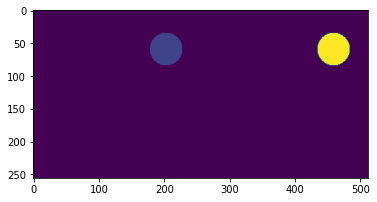

In [23]:
from monai.config import KeysCollection
from typing import Optional, Any, Mapping, Hashable


class RandAdditiveNoised(Randomizable, MapTransform):
    def __init__(
        self, keys: KeysCollection, prob: float = 0.5, max_add: float = 1.0
    ) -> None:
        super(Randomizable, self).__init__(keys)
        self.transform = RandAdditiveNoise(prob, max_add)

    def set_random_state(
        self, seed: Optional[int] = None, state: Optional[np.random.RandomState] = None
    ) -> "RandAdditiveNoised":
        self.transform.set_random_state(seed, state)
        super().set_random_state(seed, state)
        return self

    def randomize(self, data: Optional[Any] = None) -> None:
        self.transform.randomize(data)

    def __call__(
        self, data: Mapping[Hashable, np.ndarray]
    ) -> Mapping[Hashable, np.ndarray]:
        self.randomize(data[monai.utils.first(self.keys)])

        d = dict(data)
        for key in self.keys:
            d[key] = self.transform.add_noise(d[key])
        return d


trans = Compose(
    [LoadNiftid(fn_keys), AddChanneld(fn_keys), RandAdditiveNoised(("img",))]
)

img = trans(filenames[0])
print(list(img.keys()))

# note that we're adding random noise to the image alone, not the segmentation
plt.imshow(np.hstack([img["img"][0, 50], img["seg"][0, 50]]))

Se proporcionan anulaciones de métodos para delegar el comportamiento a una instancia interna de RandAdditiveNoise:

- set_random_state establece el estado del delegado y el objeto actual
- randomize delega la aleatorización a la instancia de RandAdditiveNoise
- __call__ hace que el delegado se aleatorice y luego aplica la transformación a cada miembro nombrado del diccionario. 

La transformación delegada se aleatoriza solo una vez, esto asegura que se agregue el mismo campo aleatorio a cada miembro nombrado del diccionario, se necesitaría una implementación ligeramente diferente agregando un campo aleatorio por clave si este fuera el comportamiento deseado.


# Cargando datasets
Con una fuente de datos y transformaciones definidas, ahora podemos crear un objeto de conjunto de datos. La clase base para MONAI es Conjunto de datos, creado aquí para cargar solo los archivos de imagen Nifti.

In [24]:
images = [fn["img"] for fn in filenames]

transform = Compose([LoadNifti(image_only=True), AddChannel(), ToTensor()])

ds = Dataset(images, transform)

img_tensor = ds[0]

print(img_tensor.shape, img_tensor.get_device())

torch.Size([1, 256, 256, 256]) -1


In [25]:
images

['/tmp/tmpta5wuhvn/im0.nii.gz',
 '/tmp/tmpta5wuhvn/im1.nii.gz',
 '/tmp/tmpta5wuhvn/im2.nii.gz',
 '/tmp/tmpta5wuhvn/im3.nii.gz',
 '/tmp/tmpta5wuhvn/im4.nii.gz']

El conjunto de datos hereda de la clase Pytorch de ese nombre y agrega solo la capacidad de aplicar la transformación dada a los elementos seleccionados. Si está familiarizado con la clase de Pytorch, esto funcionará de la misma manera.

MONAI proporciona el ArrayDataset para aplicaciones de entrenamiento supervisadas específicamente. Puede aceptar matrices de datos para imágenes separadas de aquellas para segmentaciones o etiquetas con sus propias transformaciones separadas. Aquí volveremos a separar los nombres de archivo de imagen y segmentación para demostrar este uso.

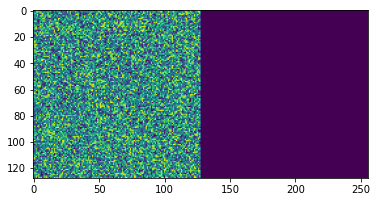

In [26]:
images = [fn["img"] for fn in filenames]
segs = [fn["seg"] for fn in filenames]

img_transform = Compose(
    [
        LoadNifti(image_only=True),
        AddChannel(),
        RandSpatialCrop((128, 128, 128), random_size=False),
        RandAdditiveNoise(),
        ToTensor(),
    ]
)

seg_transform = Compose(
    [
        LoadNifti(image_only=True),
        AddChannel(),
        RandSpatialCrop((128, 128, 128), random_size=False),
        ToTensor(),
    ]
)

ds = ArrayDataset(images, img_transform, segs, seg_transform)

im, seg = ds[0]

plt.imshow(np.hstack([im.numpy()[0, 48], seg.numpy()[0, 48]]))

En lugar de devolver una sola imagen, acceder a un miembro del conjunto de datos produce un par que contiene la imagen y la segmentación después de pasar por sus respectivas transformaciones. Un aspecto importante de esta clase es que el estado aleatorio de cada transformación (Compose en este caso) se establece en el del conjunto de datos antes de aplicarse. Esto asegura que se apliquen las mismas operaciones aleatorias a cada salida, razón por la cual la operación RandSpatialCrop elige la misma ventana de recorte para la imagen y la segmentación. Al tener transformaciones separadas se pueden aplicar operaciones a imágenes y no a segmentaciones (o viceversa), teniendo cuidado de que estas operaciones no compartidas vengan después de las compartidas.

Alternativamente, Dataset se puede usar con transformaciones basadas en diccionario para construir un mapeo de resultados. Para aplicaciones de entrenamiento más allá de los pares simples de entrada / tierra-verdad como los.anteriores, esto sería más adecuado:

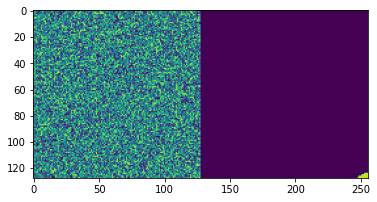

In [27]:
trans = Compose(
    [
        LoadNiftid(fn_keys),
        AddChanneld(fn_keys),
        RandAdditiveNoised(("img",)),
        RandSpatialCropd(fn_keys, (128, 128, 128), random_size=False),
        ToTensord(fn_keys),
    ]
)

ds = Dataset(filenames, trans)

item = ds[0]
im, seg = item["img"], item["seg"]

plt.imshow(np.hstack([im.numpy()[0, 48], seg.numpy()[0, 48]]))


Con el conjunto de datos definido, ahora podemos crear el cargador de datos para crear lotes de datos. Esto hereda directamente de la clase DataLoader de Pytorch con algunos cambios en los argumentos del constructor predeterminados.

['img', 'seg', 'img_meta_dict', 'seg_meta_dict'] torch.Size([5, 1, 128, 128, 128])


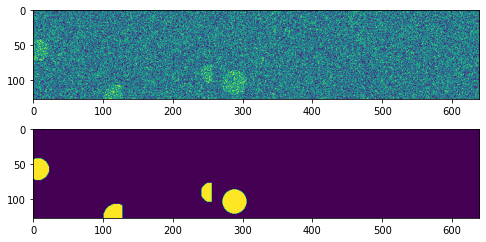

In [29]:
batch_size = 10

loader = DataLoader(ds, batch_size, num_workers=2)

batch = first(loader)

print(list(batch.keys()), batch["img"].shape)

f, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].imshow(np.hstack(batch["img"][:, 0, 64]))
ax[1].imshow(np.hstack(batch["seg"][:, 0, 64]))

Ahora finalmente tenemos un lote de entrenamiento juntos. El DataLoader anterior utilizará cinco procesos de trabajo para cargar los datos reales. MONAI proporciona una serie de subclases de conjuntos de datos para mejorar la eficiencia de este proceso. Estas y otras características se cubrirán en prácticas de laboratorio posteriores.